# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/strockis/Source/miniconda2/envs/mids/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/strockis/Source/miniconda2/envs/mids/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def P1(num_examples=5):
### STUDENT START ###

    # Iterate through training data in order
    for i in range(num_examples):
        
        # Print the body of the item
        print 'Training Data #' + str(i+1)
        print '-------------------------------------------'
        print train_data[i]
        
        # Print the topic of the item
        print '-------------------------------------------'
        print 'Topic: ' + newsgroups_train.target_names[train_labels[i]]
        
        # Print dividers between items
        print ''
        print '-------------------------------------------'
        print '-------------------------------------------'
        print ''

### STUDENT END ###
P1()

Training Data #1
-------------------------------------------
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
-------------------------------------------
Topic: comp.graphics

-------------------------------------------
-------------------------------------------

Training Data #2
-------------------------------------------


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it ne

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
from __future__ import division

def P2():
### STUDENT START ###

    # a) basic training vocabulary
    vectorizer = CountVectorizer(stop_words='english')
    feature_matrix = vectorizer.fit_transform(train_data)
    print 'Size of train vocabulary is {0} words.'.format(str(feature_matrix.shape[1]))

    # counting sparsity of matrix
    nnz_count = 0
    for document in feature_matrix:
        nnz_count += document.nnz
    print 'Average non-zero features per example is ' + str(nnz_count / feature_matrix.shape[0])
    print 'Fraction of non-zero entries in feature matrix is ' + str(nnz_count / (feature_matrix.shape[0] * feature_matrix.shape[1]))

    # b) inspecting vocabulary start & end
    print 'First feature name, alphabetically: ' + vectorizer.get_feature_names()[0]
    print 'Last feature name, alphabetically: ' + vectorizer.get_feature_names()[-1]

    # c) using a 4 word vocabulary, inspecting sparsity
    simple_vect = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
    simple_feature_matrix = simple_vect.fit_transform(train_data)
    nnz_count = 0
    for document in simple_feature_matrix:
        nnz_count += document.nnz
    print 'Average non-zero features per example with simple vocab is ' + str(nnz_count / simple_feature_matrix.shape[0])

    # d) creating bag of words model with bigrams and trigrams
    bigram_vect = CountVectorizer(analyzer='word', ngram_range=(2, 3))
    bigram_feature_matrix = bigram_vect.fit_transform(train_data)
    print 'Size of bigram & trigram vocabulary: ' + str(bigram_feature_matrix.shape[1])

    # e) excluding words that appear in less than 10 documents
    pruned_vect = CountVectorizer(min_df=10, stop_words='english')
    pruned_feature_matrix = pruned_vect.fit_transform(train_data)
    print 'Size of pruned vocabulary: ' + str(pruned_feature_matrix.shape[1])

    # f) comparing dev and train vocabularies
    dev_vect = CountVectorizer(stop_words='english')
    dev_feature_matrix = dev_vect.fit_transform(dev_data)
    print 'Size of dev vocabulary is {0} words.'.format(str(dev_feature_matrix.shape[1]))
    print 'Difference in vocabulary size between dev & train is: ' + str(feature_matrix.shape[1]-dev_feature_matrix.shape[1])

### STUDENT END ###
P2()

Size of train vocabulary is 26576 words.
Average non-zero features per example is 65.7000983284
Fraction of non-zero entries in feature matrix is 0.00247215902801
First feature name, alphabetically: 00
Last feature name, alphabetically: zyxel
Average non-zero features per example with simple vocab is 0.268436578171
Size of bigram & trigram vocabulary: 510583
Size of pruned vocabulary: 2807
Size of dev vocabulary is 15953 words.
Difference in vocabulary size between dev & train is: 10623


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [5]:
def P3():
### STUDENT START ###

    # Construct feature matrix using bag of words model
    vectorizer = CountVectorizer()
    train_feature_matrix = vectorizer.fit_transform(train_data)

    # Convert dev data into bag of words using same vocabulary
    dev_feature_matrix = vectorizer.transform(dev_data)

    # Train & evaluate KNN models
    k_values = [1, 3, 5, 6, 7, 8, 9, 10]
    for k in k_values:
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(train_feature_matrix, train_labels)
        dev_pred = knn_model.predict(dev_feature_matrix)
        print 'k = {0}: {1}'.format(str(k), str(metrics.f1_score(dev_labels, dev_pred, average='micro')))

    # Train & evaluate naive bayes models
    a_values = [0.05, 0.1, 0.2, 0.3, 0.5, 0.9, 1]
    for a in a_values:
        naive_model = MultinomialNB(alpha=a)
        naive_model.fit(train_feature_matrix, train_labels)
        dev_pred = naive_model.predict(dev_feature_matrix)
        print 'alpha = {0}: {1}'.format(str(a), str(metrics.f1_score(dev_labels, dev_pred, average='micro')))

    # Train & evaluate logistic regression models
    c_values = [0.01, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1]
    for c in c_values:
        logistic_model = LogisticRegression(C=c)
        logistic_model.fit(train_feature_matrix, train_labels)
        dev_pred = logistic_model.predict(dev_feature_matrix)
        print 'c = {0}: {1}'.format(str(c), str(metrics.f1_score(dev_labels, dev_pred, average='micro')))

        # Compute & print the weights of the model
        print 'Coef. sums: ' + str(np.square(logistic_model.coef_).sum(axis=1))

### STUDENT END ###
P3()

k = 1: 0.383136094675
k = 3: 0.414201183432
k = 5: 0.423076923077
k = 6: 0.442307692308
k = 7: 0.443786982249
k = 8: 0.440828402367
k = 9: 0.430473372781
k = 10: 0.421597633136
alpha = 0.05: 0.789940828402
alpha = 0.1: 0.792899408284
alpha = 0.2: 0.789940828402
alpha = 0.3: 0.789940828402
alpha = 0.5: 0.788461538462
alpha = 0.9: 0.784023668639
alpha = 1: 0.781065088757
c = 0.01: 0.67899408284
Coef. sums: [ 2.5415246   2.93970937  2.86246914  2.25002868]
c = 0.05: 0.69674556213
Coef. sums: [ 14.0715102   13.66983925  14.60408636  11.86068007]
c = 0.1: 0.704142011834
Coef. sums: [ 27.12919533  24.66047685  27.45966662  23.02193717]
c = 0.2: 0.713017751479
Coef. sums: [ 49.74515616  42.74318671  49.32336715  42.64866266]
c = 0.4: 0.71449704142
Coef. sums: [ 86.74142818  71.14903404  84.25856426  75.0638425 ]
c = 0.5: 0.715976331361
Coef. sums: [ 102.66870152   83.08663612   99.02623595   89.03856852]
c = 0.6: 0.71449704142
Coef. sums: [ 117.21446869   94.02923529  112.54431163  101.871974

ANSWER: Best values:
- k: 7
- alpha: 0.1
- c: 0.5

a) Nearest neighbors doesn't work well in this case because in high dimensions (here, we have >26K) every data point looks far apart. Nearest neighbors tends to break down in high dimensions.

b) Perhaps naive bayes works better in this case becuase we have such limited data. Logisitic regression tends to perform better when we have lots of data relative to the number of features, which is not the case here.

c) As the value for c increases (meaning, regularization decreases), the values for hte coefficients increase. This makes sense, since the point of L2 regularization is to limit the size of the coefficients.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [6]:
def P4():
### STUDENT START ###

    # Helper function for printing out tables
    def print_table(target_names, vectorizer, top_coefs, model):

            # Print header of table
            print '              | {0} | {1} | {2} | {3}'.format(
                target_names[0],
                target_names[1],
                target_names[2],
                target_names[3][:15],
            )
            
            # For each feature in top 20
            for i in range(len(top_coefs)):
                for j in range(len(top_coefs[0])):
                    
                    # Get the name of the feature from the vectorizer
                    name = vectorizer.get_feature_names()[top_coefs[i][j]].ljust(13)
                    
                    # Get the value of the weight, properly formatted
                    val1 = ('%.2f' % model.coef_[0][top_coefs[i][j]]).ljust(11)
                    val2 = ('%.2f' % model.coef_[1][top_coefs[i][j]]).ljust(13)
                    val3 = ('%.2f' % model.coef_[2][top_coefs[i][j]]).ljust(9)
                    val4 = ('%.2f' % model.coef_[3][top_coefs[i][j]]).ljust(11)
                    
                    # Print a row of the table
                    print '{0} | {1} | {2} | {3} | {4}'.format(
                        name,
                        val1,
                        val2,
                        val3,
                        val4
                    )

    # Create feature matrix with unigrams
    vectorizer = CountVectorizer()
    train_feature_matrix = vectorizer.fit_transform(train_data)
    
    # Train model using C value from above
    model = LogisticRegression(C=0.5)
    model.fit(train_feature_matrix, train_labels)
    
    # Find the indices of the 5 largest weights for each class
    top_coefs = []
    for cls in model.coef_:
        top_coefs.append(np.argpartition(cls, -5)[-5:])
    
    # Print out unigram table
    print_table(newsgroups_train.target_names,
               vectorizer,
               top_coefs,
               model)
    
    print ''
    
    # Create feature matrix with bigrams
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))
    train_feature_matrix = vectorizer.fit_transform(train_data)
    
    # Train model using C value from above
    model = LogisticRegression(C=0.5)
    model.fit(train_feature_matrix, train_labels)

    # Find the indices of the 5 largest weights for each class
    top_coefs = []
    for cls in model.coef_:
        top_coefs.append(np.argpartition(cls, -5)[-5:])
    
    # Print out bigram table
    print_table(newsgroups_train.target_names,
           vectorizer,
           top_coefs,
           model)
        
### STUDENT END ###
P4()

              | alt.atheism | comp.graphics | sci.space | talk.religion.m
deletion      | 0.72        | -0.25         | -0.27     | -0.27      
atheism       | 0.79        | -0.35         | -0.37     | -0.38      
atheists      | 0.83        | -0.09         | -0.27     | -0.64      
religion      | 0.80        | -0.51         | -0.66     | -0.05      
bobby         | 0.82        | -0.19         | -0.29     | -0.39      
computer      | 0.07        | 0.84          | -0.57     | -0.40      
3d            | -0.30       | 0.94          | -0.57     | -0.32      
file          | -0.28       | 1.06          | -0.68     | -0.51      
image         | -0.47       | 1.12          | -0.67     | -0.38      
graphics      | -0.64       | 1.63          | -1.10     | -0.63      
spacecraft    | -0.30       | -0.32         | 0.74      | -0.29      
launch        | -0.38       | -0.40         | 0.78      | -0.28      
nasa          | -0.47       | -0.41         | 0.85      | -0.40      
space         | 

ANSWER: In the first table, there are a couple interesting words. "bobby" in the athiest column, and "fbi" in the religion column. 

In the second table, there are more interesting cases. "are you", "you are", "was just", "it was", and so on wouldn't seem helpful, but show up in various columns. Perhaps these could be removed using stopwords next time. "cheers kent" shows up twice, in the athiesm and religion columns. Perhaps this is an email signature used by an active participant in these topics. 

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [7]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###

    # lowercase everything
    s = s.lower()
    
    # remove newlines
    s = re.sub("\n", " ", s)
    
    # remove punctuation
    s = re.sub("[\./\?\(\)',_\"]", " ", s)
    
    # remove hyperlinks
    s = re.sub("<[^>]*>", "", s)
    
    # remove carrots
    s = re.sub("[><]", "", s)
    
    return s

### STUDENT END ###

def P5():
### STUDENT START ###

    # Create feature matrix
    vectorizer = CountVectorizer(preprocessor=empty_preprocessor)
    train_feature_matrix = vectorizer.fit_transform(train_data)
    dev_feature_matrix = vectorizer.transform(dev_data)
    
    # Train model using C value from above
    model = LogisticRegression(C=0.5)
    model.fit(train_feature_matrix, train_labels)
    dev_pred = model.predict(dev_feature_matrix)
    print metrics.f1_score(dev_labels, dev_pred, average='micro')
    
    # Create feature matrix
    vectorizer = CountVectorizer(preprocessor=better_preprocessor)
    train_feature_matrix = vectorizer.fit_transform(train_data)
    dev_feature_matrix = vectorizer.transform(dev_data)
    
    # Train model using C value from above
    model = LogisticRegression(C=0.5)
    model.fit(train_feature_matrix, train_labels)
    dev_pred = model.predict(dev_feature_matrix)
    print metrics.f1_score(dev_labels, dev_pred, average='micro')
    
### STUDENT END ###
P5()

0.711538461538
0.717455621302


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

Number of non-zero weights with L2 regularization: 107516
Number of non-zero weights with L1 regularization: 1636


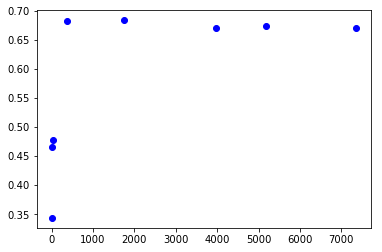

In [8]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###

    # Create feature matrix
    vectorizer = CountVectorizer()
    train_feature_matrix = vectorizer.fit_transform(train_data)
    dev_feature_matrix = vectorizer.transform(dev_data)
    
    def evaluate_pruned_model(c=1.0):

        # Train model using default C value & L1 reg
        model = LogisticRegression(penalty='l1', C=c, tol=.01)
        model.fit(train_feature_matrix, train_labels)

        # Strip feature matrix down to only columns with at least one non-zero weight
        idxs = np.nonzero(model.coef_)[1]
        pruned_feature_matrix = train_feature_matrix[:,idxs]
        vocab_size = pruned_feature_matrix.shape[1]

        # Retrain a model using default C value & L2 reg
        model = LogisticRegression(penalty='l2', C=c, tol=.01)
        model.fit(pruned_feature_matrix, train_labels)

        # Evaluate accuracy of retrained model
        dev_pruned_feature_matrix = dev_feature_matrix[:,idxs]
        dev_pred = model.predict(dev_pruned_feature_matrix)
        accuracy = metrics.accuracy_score(dev_labels, dev_pred)
    
        return (vocab_size, accuracy)
    
    
    # Train a model using default C value & L2 reg
    model = LogisticRegression(penalty='l2', C=1.0)
    model.fit(train_feature_matrix, train_labels)
    print 'Number of non-zero weights with L2 regularization: ' + str(np.count_nonzero(model.coef_))

    # Train model using default C value & L1 reg
    model = LogisticRegression(penalty='l1', C=1.0)
    model.fit(train_feature_matrix, train_labels)
    print 'Number of non-zero weights with L1 regularization: ' + str(np.count_nonzero(model.coef_))

    # Perform L1 pruning & retraining for different values of C, record results
    c_values = [0.001, 0.005, 0.01, 0.1, 1, 5, 10, 20]
    vocab_sizes = []
    accuracies = []
    for c in c_values:
        size, accuracy = evaluate_pruned_model(c)
        vocab_sizes.append(size)
        accuracies.append(accuracy)
    
    plt.plot(vocab_sizes, accuracies, 'bo')
    
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [9]:
from __future__ import division

def P7():
    ### STUDENT START ###

    # Create features using TfIdf
    vectorizer = TfidfVectorizer()
    train_feature_matrix = vectorizer.fit_transform(train_data)
    dev_feature_matrix = vectorizer.transform(dev_data)
    
    # Train a model using given regularization
    model = LogisticRegression(C=100)
    model.fit(train_feature_matrix, train_labels)
    
    # Make predictions on dev data
    dev_pred = model.predict_proba(dev_feature_matrix)
    
    # Compute ratio R for every document in dev set
    r_values = []
    for i in range(len(dev_pred)):
        r_values.append((max(dev_pred[i])) / (dev_pred[i][dev_labels[i]]))
    
    # Get the index of the top 3 r values
    idxs = np.argpartition(r_values, -3)[-3:]
    
    # Print the documents for the top 3 r values
    for doc in idxs:
        print dev_data[doc]
        print '--------------------------------------------------'

    ### STUDENT END ###
P7()


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...

--------------------------------------------------
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.
--------------------------------------------------
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit en

ANSWER: Tf-Idf is different from the Count Vectorizer in that it doesn't use simple word or bigram counts as feature values. It computes a count for each feature that is normalized by the frequency of the feature in the entire corpus of documents. So, features/words that are common in a given document but uncommon in the entire corpus are weighted more heavily in the model. This helps to de-emphasize words that are common in every document, like articles.

Based on the three documents above, it would seem the model struggles with two types of mistakes:

- short documents
- documents where online copies of religous/athiest topics are discussed. These documents contain both computer related terms such as "ftp" and "internet" as well as religous terms such as "mormon".

I would like to explore more whether short documents are in fact troublesome before suggesting any fix. But for the latter problem, it would seem that religious terms should be weighted far more heavily than computer/internet terms. For instance, in the second document, there is only one religious phrase, but that one phrase determines the topic of the entire document. Therefore, an approach to this problem would be to artificially weight religious terms. This could be done with a externally constructed list, or by inspecting the terms heavily weighted in religious documents, and heavily weighting those terms in our model. 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

Sorry, too busy to be doing extra credit today :)